# **Proyek Akhir Pengantar Sains Data-A**

---

**Kelompok 10**

1. Andika Irza Pradana (195150201111009)

2. Muhammad Ishtobir Fuady (195150200111011)

3. Putu Wahyu Kusuma Wardhana (195150207111067)

Kelas : PSD-A

## Mengimpor *Library*

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from scipy import stats

import tensorflow as tf
from keras import layers
import keras

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
tf.random.set_seed(42)

## *Load Dataset*

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d gaurav2022/mobile-health

mobile-health.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip mobile-health.zip

Archive:  mobile-health.zip
replace mhealth_raw_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mhealth_raw_data.csv    


**Membaca dataset dalam bentuk csv** `'mhealth_raw_data'` menggunakan *Library* Pandas.

In [ ]:
df = pd.read_csv('mhealth_raw_data.csv')

In [ ]:
df

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.449020,-1.01030,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.449020,-1.01030,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.449020,-1.01030,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.456860,-1.00820,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.456860,-1.00820,0.025862,0,subject1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,1.7849,-9.8287,0.29725,-0.341370,-0.90056,-0.61493,-3.7198,-8.9071,0.294230,0.041176,-0.99384,-0.480600,0,subject10
1215741,1.8687,-9.8766,0.46236,-0.341370,-0.90056,-0.61493,-3.7160,-8.7455,0.448140,0.041176,-0.99384,-0.480600,0,subject10
1215742,1.6928,-9.9290,0.16631,-0.341370,-0.90056,-0.61493,-3.8824,-9.1155,0.450480,0.041176,-0.99384,-0.480600,0,subject10
1215743,1.5279,-9.6306,0.30458,-0.341370,-0.90056,-0.61493,-3.5564,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0,subject10


Untuk DataFrame `'mhealth_raw_data'` terdiri dari 14 **kolom** dan **1215745 baris**.

## *Data Dictionary*

| Column                | Description                                                 | |    
|----------------------------|-------------------------------------------------------------|----------------------
| `alx`                    | Acceleration from the left-ankle sensor (X axis)                                         
| `aly`                | Acceleration from the left-ankle sensor (Y axis)       | 
| `alz`              | Acceleration from the left-ankle sensor (Z axis)             |  |
| `glx`                | Gyro from the left-ankle sensor (X axis)  |  |
| `gly`                  | Gyro from the left-ankle sensor (Y axis)             |  |
| `glz`                     | Gyro from the left-ankle sensor (Z axis)                                |  |
| `arx`          | Acceleration from the right-lower-arm sensor (X axis)                 |  |
| `ary`             | Acceleration from the right-lower-arm sensor (Y axis)                        |  |
| `arz`                | Acceleration from the right-lower-arm sensor (Z axis) |
| `grx`               |  Gyro from the right-lower-arm sensor (X axis)                                      |  |
| `gry`              | Gyro from the right-lower-arm sensor (Y axis)                                         |  |
| `grz`               | Gyro from the right-lower-arm sensor (Z axis)                               |  |
| `subject` | Volunteer number           |  |
| `Activity`   | Corresponding activity          | 

## *Data Preprocessing*

**Menghitung jumlah masing-masing baris** pada kolom `Activity`.

In [ ]:
df.Activity.value_counts()

0     872550
11     30720
10     30720
9      30720
5      30720
4      30720
3      30720
2      30720
1      30720
7      29441
8      29337
6      28315
12     10342
Name: Activity, dtype: int64

Terdapat **persebaran data yang tidak seimbang** pada `Activity 0` sebesar **872550 baris** dengan tipe data Integer.

Dengan adanya hal tersebut, maka hal yang harus dilakukan ialah **menyeimbangkan data** pada `Activity 0`. Kami menggunakan *library* dari Scikit Learn yaitu **Resample**. Resample digunakan untuk meresample ulang data pada array atau matriks tertentu agar mencapai konsistensi persebearan data. Disini kami melakukan pembagian data untuk `Activity 0` sebagai data mayoritas dan selain `Activity 0` sebagai data minoritas. `Activity 0` sebagai data mayoritas karena data tersebut yang akan dilakukan *resample* dengan mengatur sampel sebesar 30.000 untuk `Activity 0` dan kemudian akan digabungkan dengan data minoritasnya.

In [ ]:
df_major = df[df.Activity==0]
df_minor = df[df.Activity!=0]
 
df_downsampled = resample(df_major, n_samples=30000, random_state=42)
df = pd.concat([df_downsampled, df_minor])
df.Activity.value_counts()

11    30720
10    30720
9     30720
5     30720
4     30720
3     30720
2     30720
1     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

Sehingga dapat terlihat **persebaran data yang merata** pada setiap aktivitas yang ada.

Kemudian, melakukan pelabelan terhadap setiap aktivitas. Sebagai contoh `Activity 0` merupakan tidak ada aktivitas/berdiam diri, `Activity 1` sebagai aktivitas berdiri. Selain itu, terdapat aktivitas lainnya pada pelabelan ini. 

In [ ]:
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

## *Exploratory Data Analysis*

In [ ]:
# Membuat visualisasi 
def compare_plot(data, metric = 'acceleration'):
 
  metric = metric[0].lower()
  data = data
 
  for i in range(0,13):
    plt.figure(figsize=(16,4))
 
    plt.subplot(1,2,1)
    plt.plot(data[ data['Activity']==i ].reset_index(drop=True)[metric+'lx'], alpha=.7, label=metric+'lx')
    plt.plot(data[ data['Activity']==i ].reset_index(drop=True)[metric+'ly'],color='red', alpha=.7, label=metric+'ly')
    plt.plot(data[ data['Activity']==i ].reset_index(drop=True)[metric+'lz'],color='green', alpha=.7, label=metric+'lz')
    plt.title(f'{label_map[i]} - left-ankle')
    plt.legend()  
 
    plt.subplot(1,2,2)
    plt.plot(data[ data['Activity']==i ].reset_index(drop=True)[metric+'rx'], alpha=.7, label=metric+'rx')
    plt.plot(data[ data['Activity']==i ].reset_index(drop=True)[metric+'ry'],color='red', alpha=.7, label=metric+'ry')
    plt.plot(data[ data['Activity']==i ].reset_index(drop=True)[metric+'rz'],color='green', alpha=.7, label=metric+'rz')
    plt.title(f'{label_map[i]} - right-lower-arm')
    plt.legend() 
 
    plt.show()
    print()
 
def cat_plot(data,cat):
  array = (data[cat].value_counts().sort_values(ascending=False)/len(data))*100
  plt.barh(array.index, width = array.values)
  for index, value in enumerate(array.values):
      plt.text(value + .5 , index, s= '{:.1f}%'.format(value))
  plt.show()

Setelah melakukan pelabelan, dilakukan plotting untuk membuat diagram bar tentang **presentase jumlah data** yang ada pada masing-masing activity menggunakan fungsi yang telah dibuat di atas.

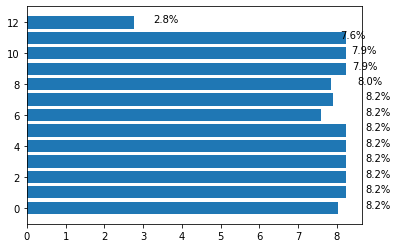

In [ ]:
cat_plot(df, 'Activity')
plt.show()

Begitu pula dengan kolom `subject`, kami membuat plotting tentang **presentase jumlah data** dari masing-masing nilai kolom `subject` menggunakan fungsi yang sama dengan sebelumnya 

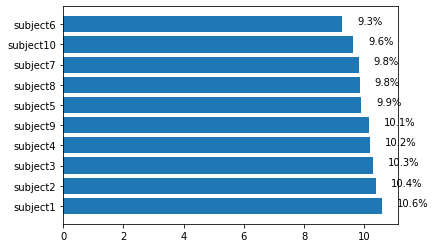

In [ ]:
cat_plot(df, 'subject')
plt.show()

Selain itu, terdapat pula plotting tentang **hubungan** antara kolom `activity` dengan kolom yang mengandung nilai dari **data acceleration** menggunakan fungsi 'compare_plot' yang dibuat sebelumnya.



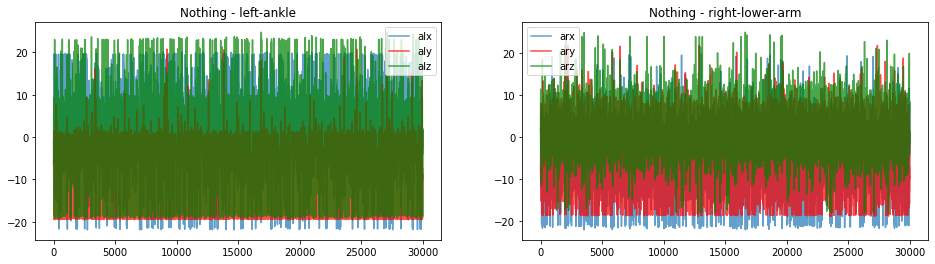

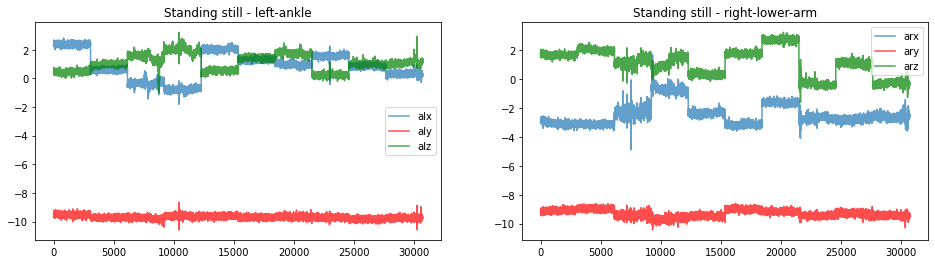

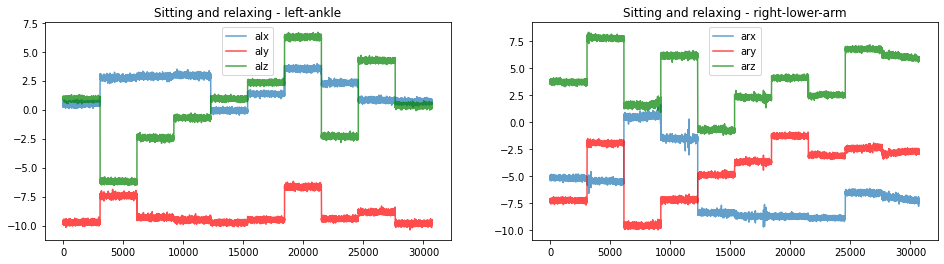

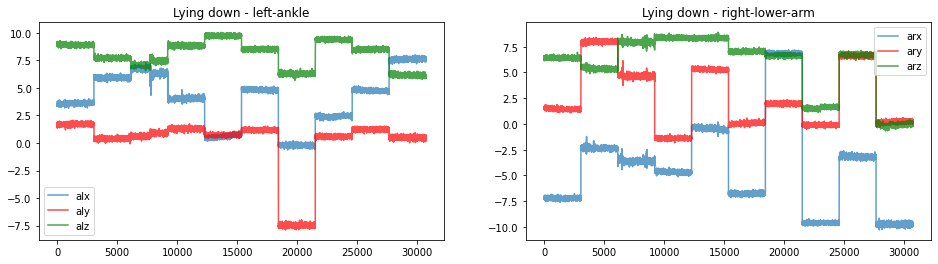

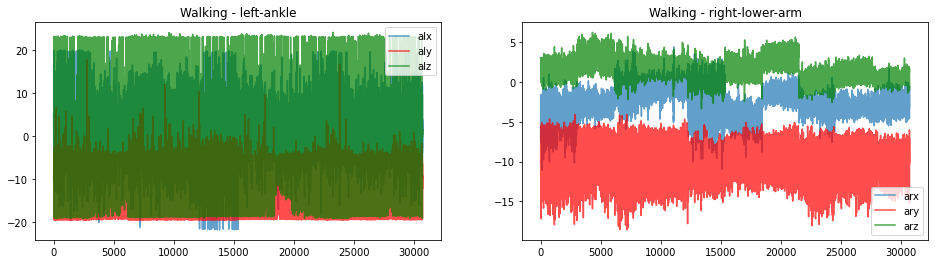

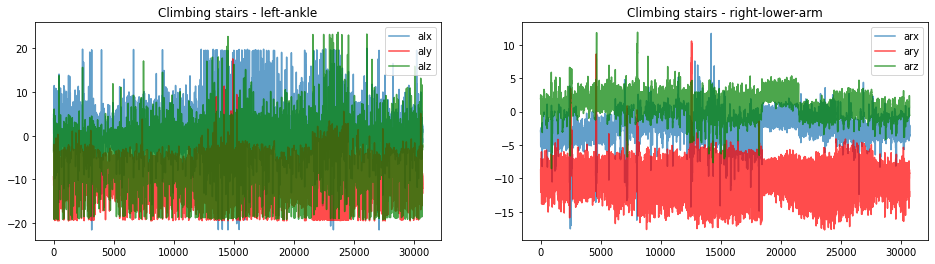

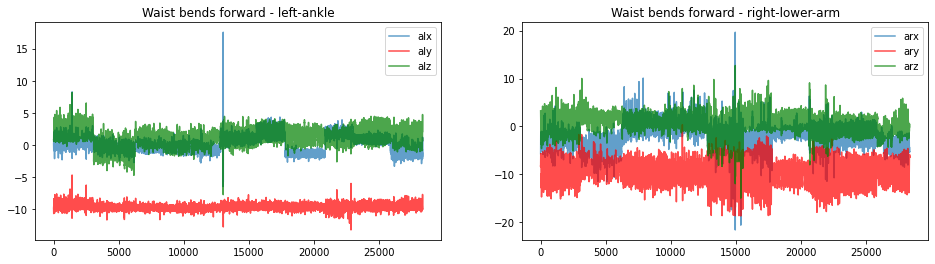

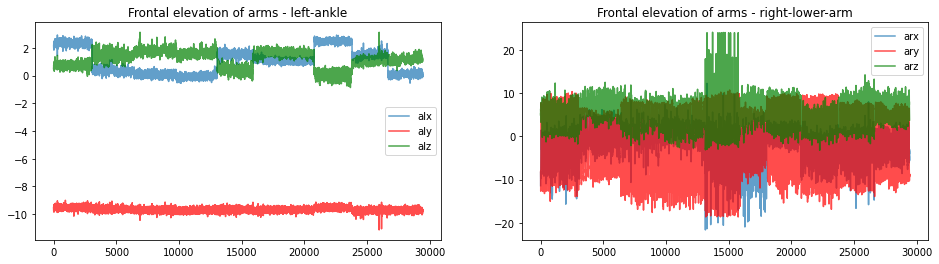

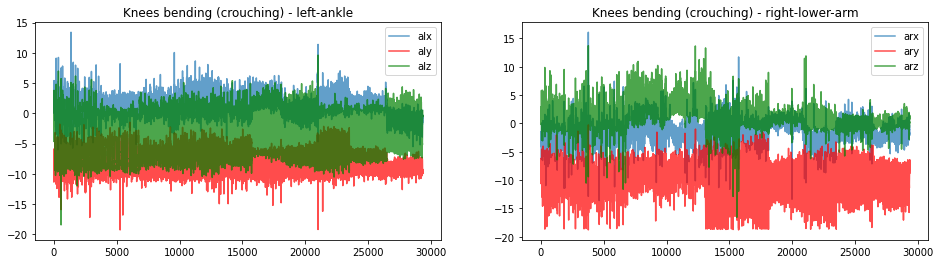

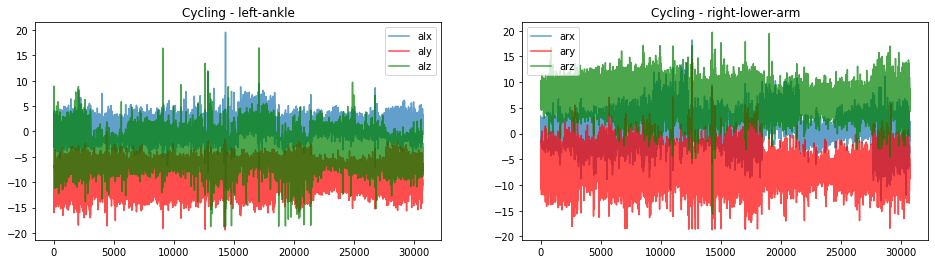

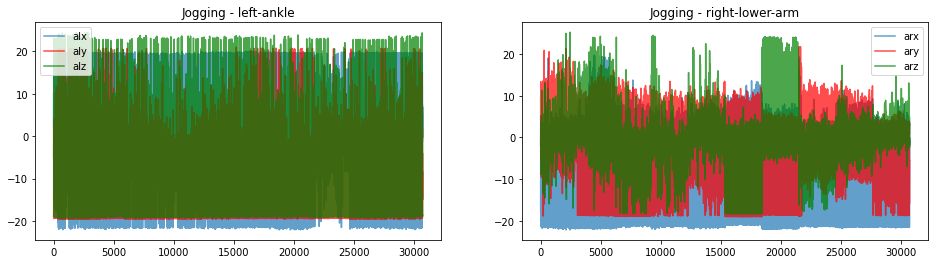

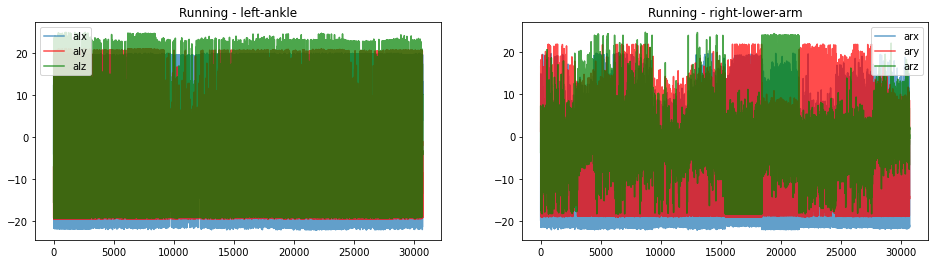

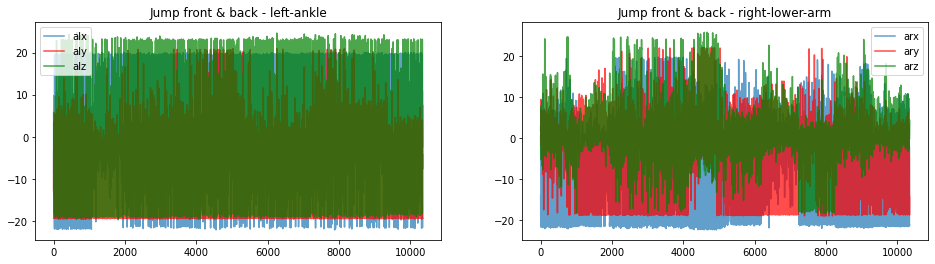

In [ ]:
compare_plot(df)

Kami juga membuat plotting untuk mengetahui **data pencilan** yang ada.

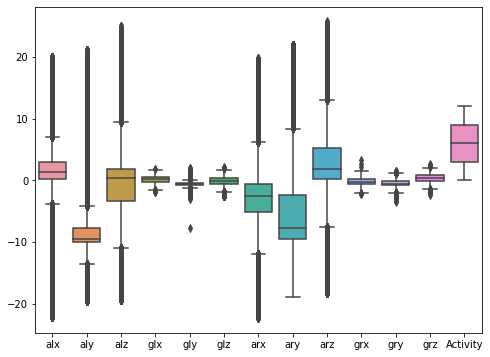

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df)
plt.show()

Dari diagram tersebut dapat diketahui bahwa **semua kolom selain `Activity`** memiliki data pencilan, terutama pada kolom yang berhubungan dengan **data akselerasi**.

Untuk mengatasi data pencilan tersebut, dilakukan penghitungan nilai rata-rata, standar deviasi, dan lain-lain.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
alx,373195.0,1.769892,4.170916,-22.1460,0.158585,1.36530,2.882800,20.0440
aly,373195.0,-9.129392,5.099059,-19.6190,-10.078000,-9.60650,-7.729550,21.1610
alz,373195.0,-0.726522,6.352714,-19.3730,-3.367750,0.29864,1.758900,25.0150
glx,373195.0,0.090064,0.463424,-1.8942,-0.356220,0.18367,0.484230,1.7941
gly,373195.0,-0.557242,0.427327,-7.7899,-0.810510,-0.69043,-0.493430,2.0038
glz,373195.0,-0.125431,0.554969,-2.6267,-0.571710,-0.11002,0.349710,2.1022
arx,373195.0,-3.479793,5.777091,-22.3450,-5.168800,-2.53510,-0.604030,19.8010
ary,373195.0,-5.783452,6.491917,-18.9720,-9.542300,-7.71090,-2.372400,21.9650
arz,373195.0,2.383944,4.147091,-18.2390,0.138490,1.83120,5.287550,25.7410
grx,373195.0,-0.209537,0.547640,-2.2392,-0.686270,-0.30784,0.250980,3.2588


In [ ]:
 df1 = df.copy()

Setelah itu kami melakukan drop terhadap fitur-fitur yang memiliki nilai convidence **kurang dari 90%**. Hasilnya disimpan pada variabel dataframe yang berbeda, yaitu `df1`.

In [ ]:
# Melakukan drop terhadap fitur dengan memiliki nilai convidence kurang dari 98%
for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)
  print(feature,'range:',lower_range,'to',upper_range)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)
  print('shape',df1.shape)

alx range: -11.473120000000002 to 19.233
shape (365733, 14)
aly range: -19.378999999999998 to 2.4478719999999976
shape (359934, 14)
alz range: -18.95 to 14.19623999999999
shape (356240, 14)
glx range: -0.74212 to 0.80705
shape (349347, 14)
gly range: -1.0694 to 0.96623
shape (342811, 14)
glz range: -1.1061 to 0.8290799999999999
shape (337361, 14)
arx range: -21.492 to 9.097647999999998
shape (332280, 14)
ary range: -18.694000000000006 to 11.948059999999998
shape (326215, 14)
arz range: -10.367 to 11.823119999999996
shape (323650, 14)
grx range: -1.0196 to 0.95686
shape (320165, 14)
gry range: -1.1417 to 0.90965
shape (315329, 14)
grz range: -0.69828 to 1.125
shape (310906, 14)


Dilakukan pengecekan nilai pencilan sekali lagi.

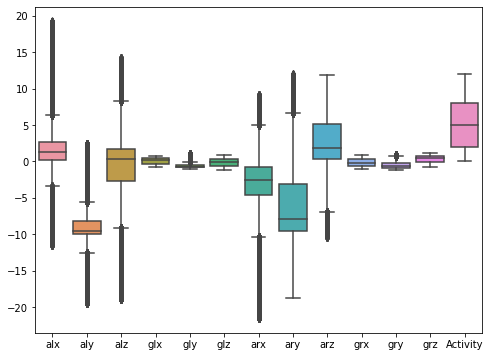

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df1)
plt.show()

Dari pengecekan kedua tersebut, didapati bahwa jumlah nilai pencilan telah **berkurang** dari **data sebelumnya**.

## *Data Preparation*

Pada tahapan preparation, kami melakukan pengecekan tipe data dari masing-masing kolom terlebih dahulu.

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310906 entries, 154060 to 1213645
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alx       310906 non-null  float64
 1   aly       310906 non-null  float64
 2   alz       310906 non-null  float64
 3   glx       310906 non-null  float64
 4   gly       310906 non-null  float64
 5   glz       310906 non-null  float64
 6   arx       310906 non-null  float64
 7   ary       310906 non-null  float64
 8   arz       310906 non-null  float64
 9   grx       310906 non-null  float64
 10  gry       310906 non-null  float64
 11  grz       310906 non-null  float64
 12  Activity  310906 non-null  int64  
 13  subject   310906 non-null  object 
dtypes: float64(12), int64(1), object(1)
memory usage: 35.6+ MB


Kami melakukan pengecekan terhadap nilai null dari masing-masing kolom juga.

In [ ]:
df1.isnull().sum()

alx         0
aly         0
alz         0
glx         0
gly         0
glz         0
arx         0
ary         0
arz         0
grx         0
gry         0
grz         0
Activity    0
subject     0
dtype: int64

Setelah itu, dilakukan splitting data menjadi data latih dan data uji.

In [ ]:
# Melakukan splitting data
train = df1[(df1['subject'] != 'subject10') & (df1['subject'] != 'subject9')]
test = df1.drop(train.index, axis=0)
train.shape, test.shape

((246483, 14), (64423, 14))

Pada proses splitting ini **tidak** dilakukan splitting secara **acak**. Akan tetapi kami melakukan splitting dengan cara menjadikan data yang memiliki **fitur `subject9` dan `subject10`** sebagai **data uji** dan **sisanya** sebagai **data latih**.

Kemudian dilakukan pemisahan terhadap kolom **`Activity`** sebagai **target**. Dilakukan juga drop kolom `subject` karena tidak dibutuhkan lagi.

In [ ]:
X_train = train.drop(['Activity','subject'], axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity','subject'], axis=1)
y_test = test['Activity']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((246483, 12), (246483,), (64423, 12), (64423,))

In [ ]:
# Fungsi untuk membuat dataset time series
def df1_ts(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
X_train, y_train = df1_ts(X_train, y_train, 100, step=50)
X_train.shape, y_train.shape

((4928, 100, 12), (4928, 1))

In [ ]:
X_test, y_test = df1_ts(X_test, y_test, 100, step=50)
X_test.shape, y_test.shape

((1287, 100, 12), (1287, 1))

## *Modelling*

In [ ]:
model = keras.Sequential()
model.add(layers.Input(shape=[100,12]))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.LSTM(64))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 100, 32)           1184      
                                                                 
 batch_normalization_2 (Batc  (None, 100, 32)          128       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 100, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 64)           6208      
                                                                 
 batch_normalization_3 (Batc  (None, 100, 64)          256       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 100, 64)          

Pada tahap modelling ini memakai metode deep learning. Dalam penerapan deep learning, kami memakai salah satu open source API dari deep learning yang dikenal dengan keras. Dapat dilihat pada baris 1 terdapat kode untuk membuat sequential model baru. Selanjutnya, dipanggil beberapa method yang akan digunakan. Terakhir, kami memanggil ringkasan proses dari model jaringan.


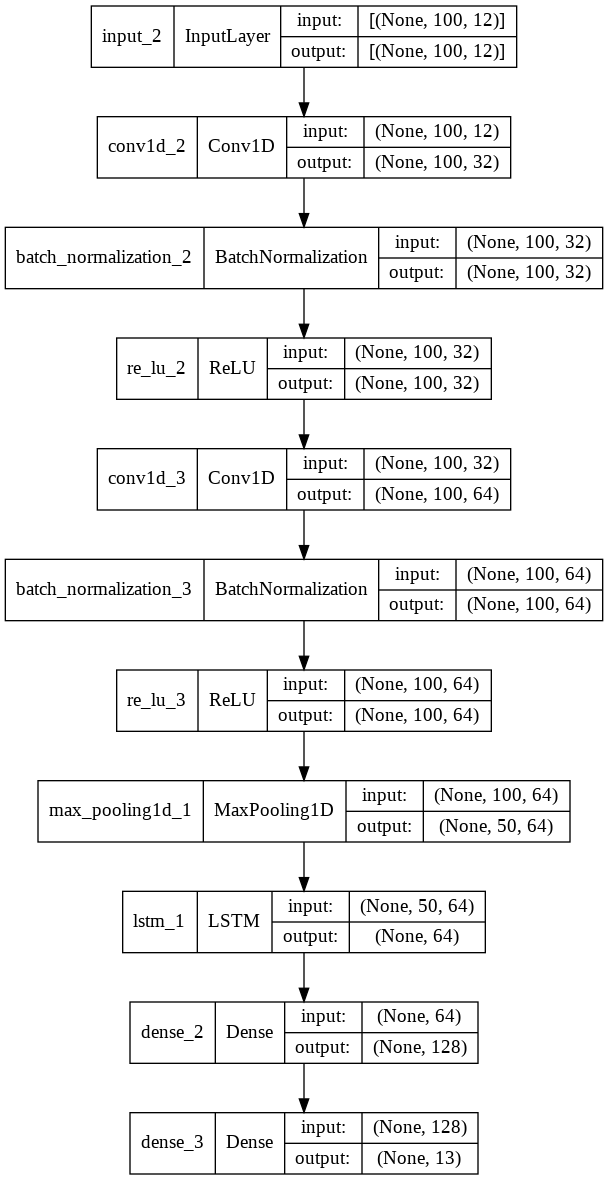

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Dari gambar diatas, dapat dilihat info dari ringkasan hasil model sebelumnya dalam bentuk diagram.

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("mhealth_best.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]
 
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)
 
model_history = model.fit(X_train, y_train, epochs= 10, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/10
154/154 [==============================] - 9s 45ms/step - loss: 0.7780 - sparse_categorical_accuracy: 0.7595 - val_loss: 2.3222 - val_sparse_categorical_accuracy: 0.3776
Epoch 2/10
154/154 [==============================] - 6s 41ms/step - loss: 0.1785 - sparse_categorical_accuracy: 0.9409 - val_loss: 0.3618 - val_sparse_categorical_accuracy: 0.9083
Epoch 3/10
154/154 [==============================] - 6s 41ms/step - loss: 0.0905 - sparse_categorical_accuracy: 0.9730 - val_loss: 0.2278 - val_sparse_categorical_accuracy: 0.9487
Epoch 4/10
154/154 [==============================] - 6s 41ms/step - loss: 0.0644 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.0828 - val_sparse_categorical_accuracy: 0.9759
Epoch 5/10
154/154 [==============================] - 6s 40ms/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.6469 - val_sparse_categorical_accuracy: 0.8632
Epoch 6/10
154/154 [==============================] - 6s 41ms/step - loss: 0.0636 - sparse_cate

Dari gambar, loss turun secara signifikan dan akurasinya hampir 100%. Untuk menguji model, diambil
secara acak dan meletakkannya dengan kelas yang berbeda untuk menguji.

## *Evaluation*

Setelah melakukan modelling, maka kami lanjut ke tahap evaluation atau evaluasi dari model.

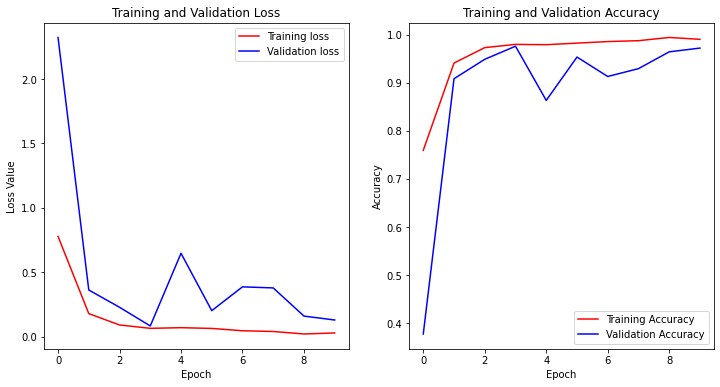

In [ ]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['sparse_categorical_accuracy']
val_accuracy = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model = keras.models.load_model('./mhealth_best.h5')

train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Train accuracy", round(train_acc*100, 2),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 2),'%')
print("Test loss", test_loss)

41/41 [==============================] - 1s 12ms/step - loss: 0.0828 - sparse_categorical_accuracy: 0.9759
Train accuracy 99.21 %
Train loss 0.02846216782927513
Test accuracy 97.59 %
Test loss 0.08282721787691116


Pada langkah diatas, dilakukan evaluasi terhadap model sehingga didapatkan akurasi dari data train sebesar 99,21 % dan data test sebesar 97,59 %.

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
pred = pred.reshape(-1,1)

In [ ]:
pred.shape, y_test.shape

((1287, 1), (1287, 1))

In [ ]:
print(classification_report(y_test,pred))
print('='*54)
print()
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        92
           1       1.00      1.00      1.00       122
           2       1.00      0.99      1.00       124
           3       0.99      0.99      0.99       122
           4       0.98      1.00      0.99       120
           5       0.85      0.94      0.89        84
           6       0.97      0.99      0.98       106
           7       1.00      0.98      0.99       112
           8       0.95      0.87      0.91       116
           9       0.98      1.00      0.99       121
          10       0.97      0.99      0.98        89
          11       0.98      0.98      0.98        52
          12       1.00      0.89      0.94        27

    accuracy                           0.98      1287
   macro avg       0.98      0.97      0.97      1287
weighted avg       0.98      0.98      0.98      1287


[[ 91   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0 122   0   0   0  

Setelah berhasil mendapatkan akurasi dari model, maka pada tahap diatas dibuat evaluasi laporan yang menunjukan classification metrics. Selain itu, ditampilkan juga confusion matrix untuk hubungan multi-class. 

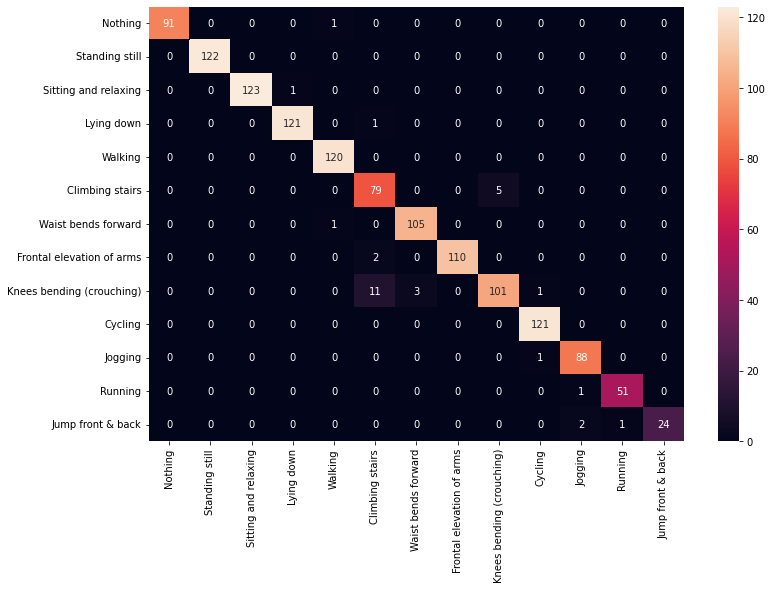

In [ ]:
plt.figure(figsize=(12,8))
conf_matrix = confusion_matrix(y_test, pred)
sns.heatmap(conf_matrix, xticklabels= label_map.values(), yticklabels= label_map.values(), annot=True, fmt="d")
plt.show()

Dari confusion matrix diatas, didapatkan beberapa hubungan multi-class.